In [ ]:
# A small demo related to the usage of Ideal Centroid Striving classification method

In [1]:
pip install stumpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 2.4 MB/s eta 0:00:00


In [2]:
# Connect to google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%ls

drive/  sample_data/


In [4]:
# Clone the GitHub repository
removed

Cloning into 'dissertation-code'...
remote: Enumerating objects: 274, done.
remote: Counting objects: 100% (274/274), done.
remote: Compressing objects: 100% (176/176), done.
remote: Total 274 (delta 155), reused 203 (delta 87), pack-reused 0
Receiving objects: 100% (274/274), 3.78 MiB | 4.82 MiB/s, done.
Resolving deltas: 100% (155/155), done.


In [ ]:
# %cd dissertation-code/
%cd lucrare/

In [6]:
import itertools
import copy
import json

In [7]:
from src.main.io_utils import import_csv_as_df, import_pkl_obj
from src.main.cycle_utils import *
from src.main.plot_utils import *
from src.main.sampling_utils import *
from src.main.matching_utils import *
from src.model.IdealCentroidStriving import *
from src.model.model_utils import *

In [91]:
# Several datasets used in the experiments; they are organized as csv files
# For this example, the instances (dataset's rows) are extracted from a time series, but usually, a tabular dataset is given directly to ICS
# string key -> tuple with 3 values: path to csv with ts data, path to pkl with cycles starting indexes, cycle len
scamp_data_paths = dict()
scamp_data_paths['B827EB019C33'] = ("/content/drive/MyDrive/dissertation-data-usage-backup/B827EB019C33_sid_1.csv",
                                    "/content/drive/MyDrive/dissertation-data-usage-backup/B827EB019C33_sid_1_cycles_binary.pkl",
                                    24)

scamp_data_paths['B827EB722606'] = ( "/content/drive/MyDrive/dissertation-data-usage-backup/B827EB722606_sid_1.csv",
                             "/content/drive/MyDrive/dissertation-data-usage-backup/B827EB722606_sid_1_cycles_binary.pkl",
                              17)


In [92]:
# read csv and pkl data from files

def import_data_and_cycles_idx(csv_path, pkl_path):
  # import csv file with time series data
  df1 = import_csv_as_df(csv_path)
  data1 = scale_df_data(df1)

  # import pkl object with cycles indexes
  matches = import_pkl_obj(pkl_path)

  return data1, matches

# extract cycles form time series using indexes extracted via stumpy
def extract_cycles(data_from_csv, cycle_idx_matches, pattern_len_val):
  cycles_indexes = [pair[1] for pair in cycle_idx_matches]
  cycles_indexes = extract_non_overlayed_cycles_indexes(cycles_indexes, pattern_len=pattern_len_val)
  cycles = extract_cycles_from_ts(cycles_indexes, pattern_len_val, data_from_csv)

  return cycles

def import_cycles_from_pkl(file_path):
  cycles = import_pkl_obj(file_path)
  return cycles


In [93]:
scamp_data_hosts = ['B827EB019C33', 'B827EB722606']
scamp_data_selected_host = scamp_data_hosts[0] # change here to select other dataset
csv_path, pkl_path, pattern_len = scamp_data_paths[scamp_data_selected_host]

ts_data, matches = import_data_and_cycles_idx(csv_path, pkl_path)
cycles = extract_cycles(ts_data, matches, pattern_len)

In [94]:
# 'cycles' variable represent the dataset: it contains 161631 instances and 24 features
print(len(cycles))
print(len(cycles[0]))
print(cycles[0])

161631
24
[0.49358168 0.49735716 0.51875157 0.54316637 0.69166876 0.68814498
 0.66901586 0.66725396 0.64208407 0.68084571 0.68638309 0.68084571
 0.6821042  0.69468915 0.68512459 0.59048578 0.56858797 0.70425371
 0.64611125 0.5612887  0.55247923 0.62068966 0.58092122 0.55122074]


In [14]:
# Use ICS directly, without to access all the stages (steps) behind

ics_clf = IdealCentroidStriving(anomalous_points_threshold_no = 12)
ics_clf.fit(cycles) # fit the data (cycles, i.e. instances) in the classifier
ics_clf.transform() # peform the training


In [15]:
# Print some components from the model's creation report
#ics_clf.report.keys()

for report_key in ['min_anomalous_points_per_cycle', 'anomalous_cycles_no', 'anomalous_cycles_percentage', 'anomalous_pos_abs_freq']:
  print(report_key, " : ", ics_clf.report[report_key])

min_anomalous_points_per_cycle  :  12
anomalous_cycles_no  :  5587
anomalous_cycles_percentage  :  0.03456638887342156
anomalous_pos_abs_freq  :  [5055. 5143. 4927. 4594. 4859. 5161. 5334. 5347. 5378. 5369. 5363. 5367.
 5327. 5318. 5078. 4450. 4431. 4912. 4769. 4931. 4951. 4888. 5157. 4581.]


In [16]:
# Now, the ICS model creation step by step

In [48]:
# Split data into two samples for training and testing
instances = cycles[:]
x_train, x_test = split_into_2_samples(instances, size = 0.9)

In [49]:
# Initalize ICS classifier with specific parameters
ics_clf = IdealCentroidStriving(bins_no ="auto", anomalous_cumulated_threshold = 0.03, anomalous_points_threshold_no = 12,
                 min_sw_size = 4, max_sw_size = 14, estimators_no = 10, windows_selection_strategy ="best", sp_computation_method ="sub",
                 min_sss_p = 0.3, max_sss_p = 0.55, ss_ap = 0.02, ics_ccm = "avg")
ics_clf.fit(x_train)

In [50]:
# Unit level anomaly: create anomalous bins
anomalous_labelers = ics_clf.create_anomalous_labelers(0.03, ics_clf.bins_number)

In [51]:
# Instance level anomaly
# - assign artificial labels to dataset instances
labeled_instances = ics_clf.assign_artificial_labels(anomalous_labelers, anomalous_points_no = 12)

In [52]:
# Compute absolute and relative frequencies for features indexes of anomalous values
anomalous_pos_abs_freq, anomalous_pos_relative_freq = ics_clf.compute_anomalous_points_freq_by_pos(labeled_instances)

Text(0.5, 1.0, 'Absolute frequencies for feature indexes of anomalous points')

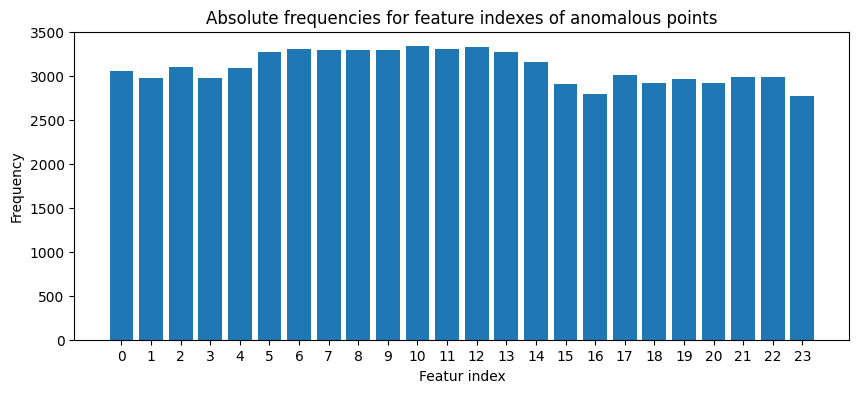

In [53]:
# Plot the absolute frequencies values
import matplotlib.pyplot as plt

cycle_len = 24
plt.figure(figsize=(10,4))
plt.bar(range(cycle_len), anomalous_pos_abs_freq)

plt.xticks(range(cycle_len), range(cycle_len))
plt.xlabel('Featur index')
plt.ylabel('Frequency')
plt.title('Absolute frequencies for feature indexes of anomalous points')

In [54]:
# Create the report and print the percentage of artificial anomalous instances
ics_clf.update_report_multi_items(labeled_instances, anomalous_pos_abs_freq)

print(ics_clf.report['anomalous_cycles_percentage'] )

0.02489224360164161


In [96]:
# create window item objects
sw_objects = ics_clf.create_window_item_instances(ics_clf.min_sw_size, ics_clf.max_sw_size,
                                                      anomalous_pos_abs_freq, anomalous_pos_relative_freq)

In [97]:
# select windows item objects for model estimators
window_item_objects = ics_clf.select_top_window_items(sw_objects, ics_clf.estimators_no, "best")

In [65]:
# create ics estimators
ics_estimators  = ics_clf.create_ICS_estimators(window_item_objects)

In [66]:
# train ICS estimators
ics_clf.perform_training(labeled_instances, ics_clf.min_sss_p,  ics_clf.max_sss_p, ics_clf.ss_ap)

In [67]:
# Perform prediction

ics_predicted_labels = ics_clf.predicts(x_test, percentile_rank = 98)
ics_label_types = (0, 1)
ics_res = (ics_predicted_labels, ics_label_types)

In [74]:
# Train and perform prediction using a Isolation Forest (IF) model
if_predicted_labels = execute_isolation_forest(x_train, x_test, contamination_value  = 0.024)
if_label_types = (1, -1)
if_res = (if_predicted_labels, if_label_types)

In [75]:
# Compare the predicted labels provided by ICS with the labels provided by IF

matching_res = two_way_matching(ics_predicted_labels, if_predicted_labels, ics_label_types, if_label_types)
matching_report = two_way_matching_report(count_labels_by_types(ics_predicted_labels, ics_label_types), count_labels_by_types(if_predicted_labels, if_label_types), matching_res)

for key_val, data_val in matching_report.items():
  print(key_val, " : ", data_val)

instances  :  16164
m1_normal_instances  :  15784
m1_anomalous_instances  :  380
m2_normal_instances  :  15783
m2_anomalous_instances  :  381
normal_instances_matches  :  15779
anomalous_instances_matches  :  376
wrong_matches  :  9


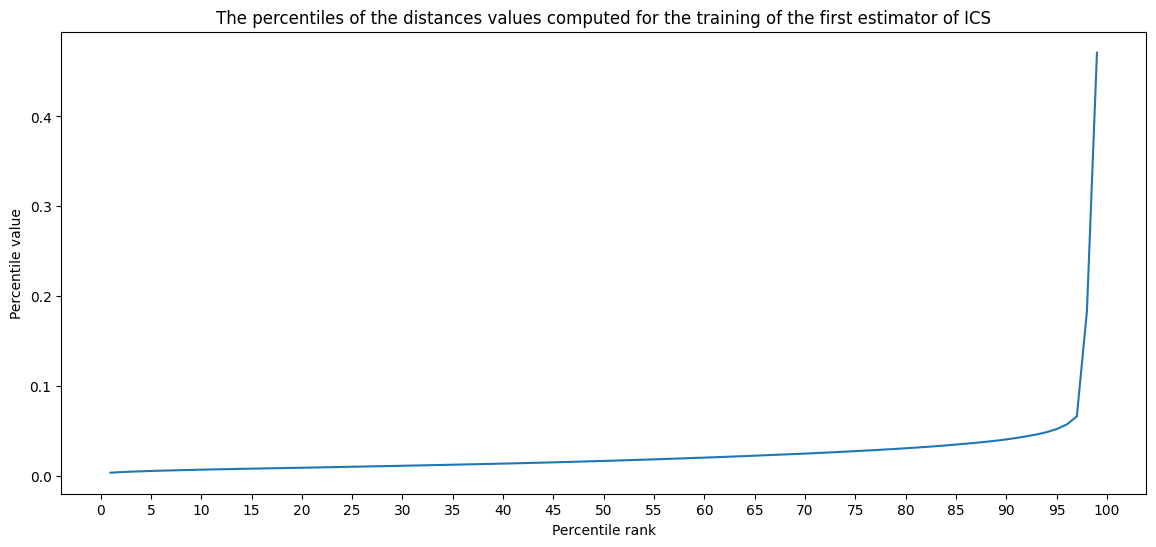

In [90]:
x_vals = list(range(1, 100))
y_vals =  [percentile_value for percentile_rank, percentile_value in ics_clf.ics_estimators[0].percentiles.items()]

plt.figure(figsize=(14, 6))
plt.xticks(np.arange(0, 101, 5))
plt.title('The percentiles of the distances values computed for the training of the first estimator of ICS')
plt.xlabel('Percentile rank')
plt.ylabel('Percentile value')


plt.plot(x_vals, y_vals)